In [3]:
# Step 1: Load and explore the dataset

import pandas as pd

# Load the dataset
path = r"C:\Users\Hawraa\Downloads\exported_students_data.csv"
df = pd.read_csv(path)

# Display columns
print(" Columns in the dataset:")
print(df.columns.tolist())

# Preview the data
print("\n First 5 rows:")
print(df.head())

# Check for missing values
print("\n Missing values:")
print(df.isnull().sum())

# Summary statistics
print("\n Summary statistics:")
print(df.describe(include='all'))


 Columns in the dataset:
['Full Name', 'Academic Performance', 'Attendance Percentage', 'Seat Zone', 'Grades', 'Academic Stress', 'Motivation', 'Depression', 'Sleep Disorder', 'Study Life Balance', 'Family Pressures', 'Parents Marital Status', 'Family Income Level', 'Housing Status', 'Has Private Study Room', 'Daily Food Availability', 'Has School Uniform', 'Has Stationery', 'Receives Private Tutoring', 'Daily Study Hours', 'Works After School', 'Has Electronic Device', 'Device Usage Purpose', 'Has Social Media Accounts', 'Daily Screen Time', 'Social Media Impact On Studies', 'Content Type Watched', 'Plays Video Games', 'Daily Gaming Hours']

 First 5 rows:
           Full Name Academic Performance  Attendance Percentage Seat Zone  \
0     Joshua Douglas              Average                  86.16    Middle   
1  Christine Houston              Average                  96.45      Back   
2        Jill Joseph              Average                  75.05      Back   
3      Kelly Johnson  

In [5]:
import numpy as np

# Function to extract scores and compute GPA
def parse_grades(grades_str):
    parts = grades_str.split(';')
    scores = []
    for part in parts:
        if ':' in part:
            try:
                _, score = part.split(':')
                scores.append(float(score.strip()))
            except:
                continue
    return np.mean(scores) if scores else np.nan

# Apply GPA calculation
df['Calculated_GPA'] = df['Grades'].apply(parse_grades)

# Preview the results
print(" GPA Calculation Example:")
print(df[['Grades', 'Calculated_GPA']].head())


 GPA Calculation Example:
                                              Grades  Calculated_GPA
0  Mathematics:69.91; Art:59.74; Physics:64.29; C...        63.16500
1  Mathematics:57.80; Art:54.81; Physics:48.67; C...        53.11750
2  Mathematics:59.54; Art:65.64; Physics:68.57; C...        65.11125
3  Mathematics:64.63; Art:63.91; Physics:63.36; C...        66.57875
4  Mathematics:63.96; Art:67.25; Physics:65.06; C...        64.24250


In [7]:
# Function to classify performance based on GPA and attendance
def classify_performance(gpa, attendance):
    if pd.isnull(gpa) or pd.isnull(attendance):
        return "Unknown"
    
    if gpa >= 90:
        label = "Excellent"
    elif gpa >= 80:
        label = "Very Good"
    elif gpa >= 70:
        label = "Good"
    elif gpa >= 60:
        label = "Average"
    else:
        label = "Needs Improvement"
    
    # Adjust based on attendance
    if attendance >= 95:
        if label == "Very Good":
            label = "Excellent"
        elif label == "Good":
            label = "Very Good"
        elif label == "Average":
            label = "Good"
        elif label == "Needs Improvement":
            label = "Average"
    elif attendance < 80:
        if label == "Excellent":
            label = "Very Good"
        elif label == "Very Good":
            label = "Good"
        elif label == "Good":
            label = "Average"
        elif label == "Average":
            label = "Needs Improvement"
    
    return label

# Apply classification
df['performance_label'] = df.apply(
    lambda row: classify_performance(row['Calculated_GPA'], row['Attendance Percentage']),
    axis=1
)

# Preview
print(df[['Calculated_GPA', 'Attendance Percentage', 'performance_label']].head())


   Calculated_GPA  Attendance Percentage  performance_label
0        63.16500                  86.16            Average
1        53.11750                  96.45            Average
2        65.11125                  75.05  Needs Improvement
3        66.57875                  92.53            Average
4        64.24250                  75.28  Needs Improvement


In [9]:
# Ordinal encoding for ranked categories
ordinal_maps = {
    'Academic Stress': {'Low': 1, 'Moderate': 2, 'High': 3},
    'Motivation': {'Low': 1, 'Moderate': 2, 'High': 3},
    'Study Life Balance': {'Needs Improvement': 1, 'Moderate': 2, 'Good': 3},
    'Family Pressures': {'None': 0, 'Low': 1, 'Moderate': 2, 'High': 3},
    'Sleep Disorder': {'None': 0, 'Low': 1, 'Moderate': 2, 'High': 3}
}

for col, mapping in ordinal_maps.items():
    df[col] = df[col].map(mapping)

# Boolean columns to convert to integers
bool_cols = [
    'Depression', 'Has Private Study Room', 'Daily Food Availability',
    'Has School Uniform', 'Has Stationery', 'Receives Private Tutoring',
    'Works After School', 'Has Electronic Device', 'Has Social Media Accounts',
    'Plays Video Games'
]

for col in bool_cols:
    df[col] = df[col].astype(int)

# Preview
df[bool_cols + list(ordinal_maps.keys())].head()


Depression  Has Private Study Room  Daily Food Availability  \
0           0                       0                        1   
1           0                       0                        1   
2           1                       1                        0   
3           0                       1                        0   
4           1                       0                        0   

   Has School Uniform  Has Stationery  Receives Private Tutoring  \
0                   1               1                          1   
1                   0               0                          1   
2                   1               1                          0   
3                   0               1                          1   
4                   1               1                          0   

   Works After School  Has Electronic Device  Has Social Media Accounts  \
0                   1                      0                          0   
1                   1                      0                          0   
2                   1                      1                          1   
3                   0                      0                          0   
4                   1                      1                          0   

   Plays Video Games  Academic Stress  Motivation  Study Life Balance  \
0                  1                3           2                   1   
1                  0                3           3                   3   
2                  0                1           3                   3   
3                  1                2           1                   3   
4                  1                2           3                   3   

   Family Pressures  Sleep Disorder  
0               1.0             2.0  
1               2.0             3.0  
2               NaN             2.0  
3               3.0             3.0  
4               NaN             2.0

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Exclude unencoded textual columns
exclude_columns = [
    "Full Name", "Grades", "Academic Performance", "Seat Zone",
    "Parents Marital Status", "Housing Status", "Device Usage Purpose",
    "Social Media Impact On Studies", "Content Type Watched"
]

# Prepare the data
df_model = df.drop(columns=exclude_columns)
df_model = df_model.dropna()

X = df_model.drop(columns=["performance_label"])
y = df_model["performance_label"]

 # Encode the labels

le = LabelEncoder()
y_enc = le.fit_transform(y)

 # Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

# Train the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# prediction
y_pred = dt_model.predict(X_test)

# evaluation
print(f" Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ===== ROC Curve =====
#  y_test to binarized format
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_score = dt_model.predict_proba(X_test)
n_classes = y_test_binarized.shape[1]

# ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Curve
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    class_name = le.inverse_transform([i])[0]
    plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


 Accuracy: 0.9910

 Classification Report:
                   precision    recall  f1-score   support

          Average       0.99      0.98      0.99       138
        Excellent       0.97      1.00      0.98        32
             Good       0.99      1.00      1.00       121
Needs Improvement       0.99      1.00      0.99       201
        Very Good       1.00      0.98      0.99        64

         accuracy                           0.99       556
        macro avg       0.99      0.99      0.99       556
     weighted avg       0.99      0.99      0.99       556


 Confusion Matrix:
[[135   0   1   2   0]
 [  0  32   0   0   0]
 [  0   0 121   0   0]
 [  1   0   0 200   0]
 [  0   1   0   0  63]]


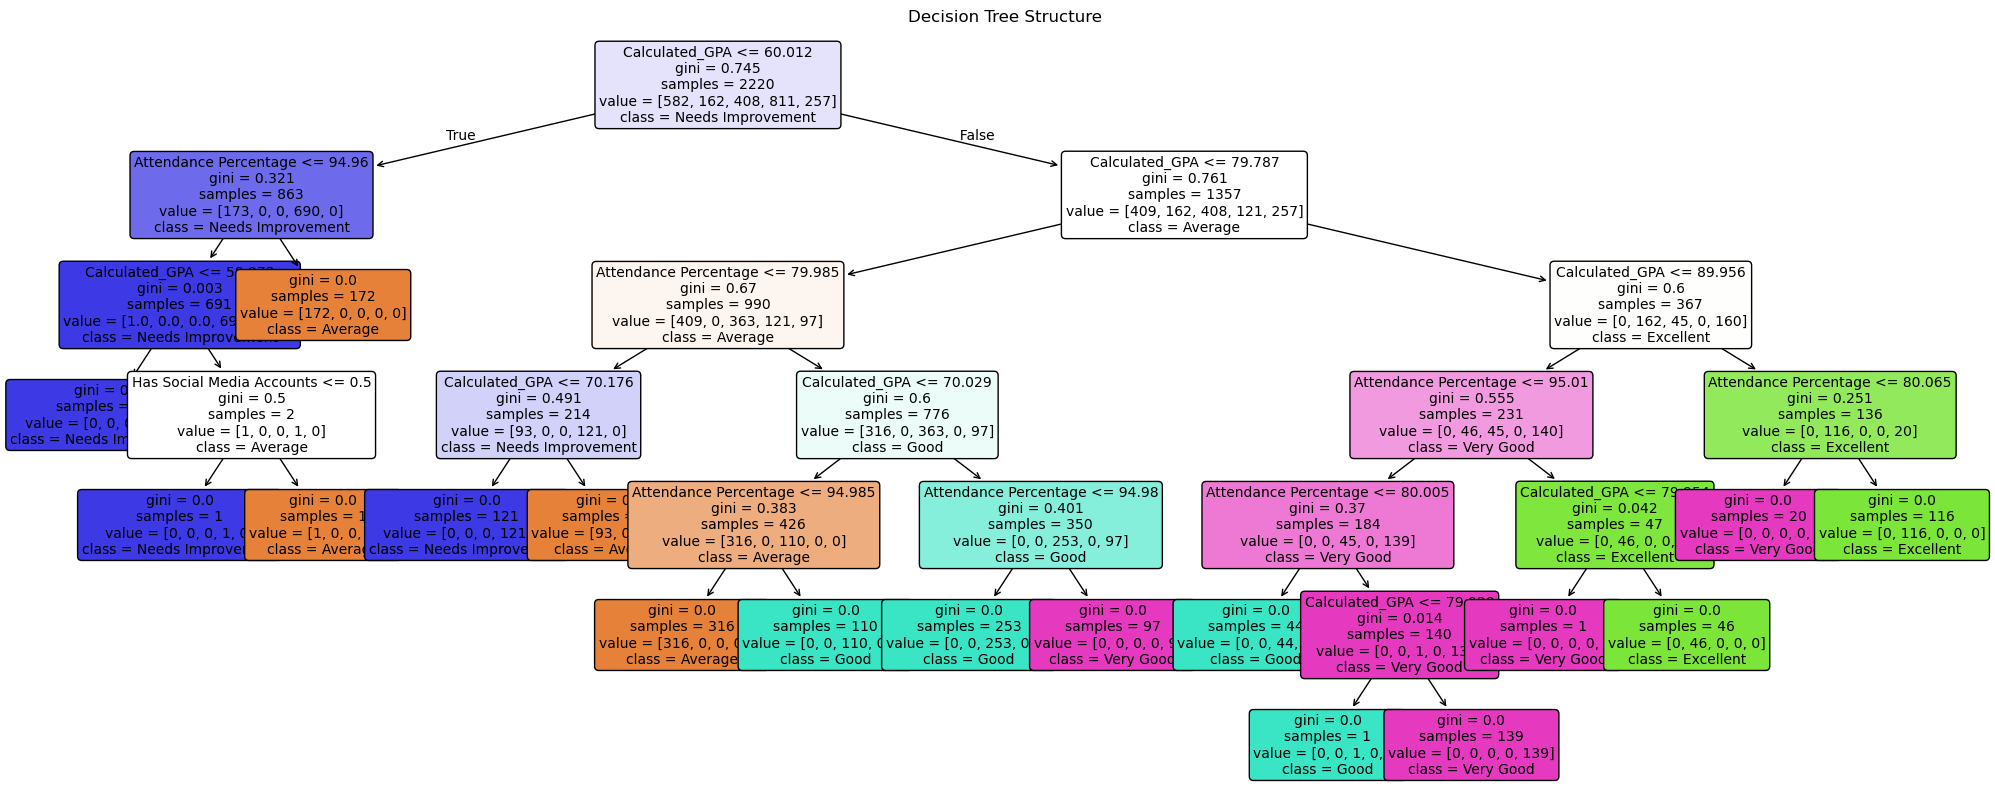

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Draw Decision Tree
plt.figure(figsize=(25, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=le.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()


In [17]:
!pip install shap


   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   -------------------------------------- - 524.3/545.2 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 545.2/545.2 kB 2.3 MB/s eta 0:00:00


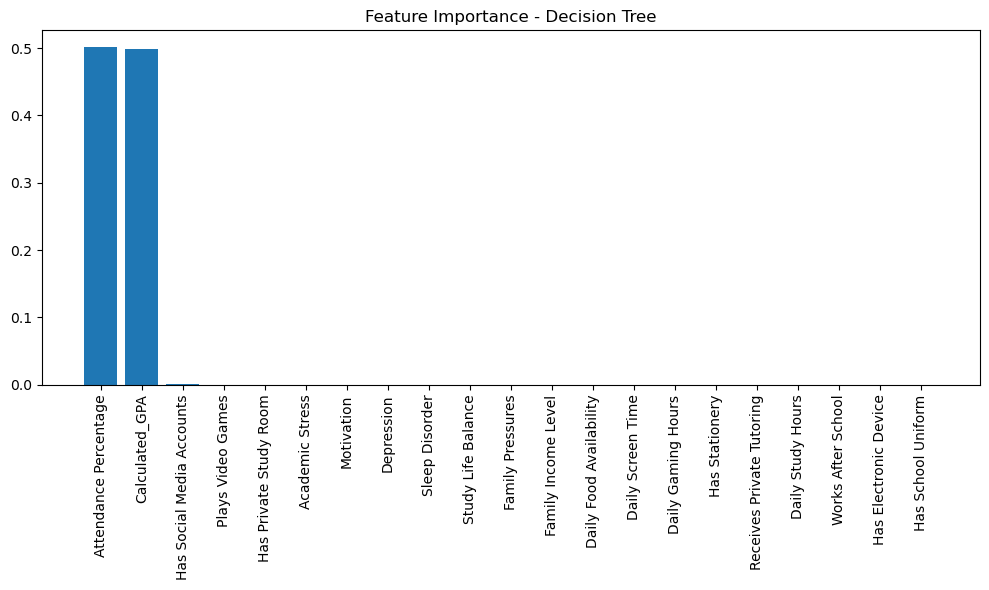

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the decision tree model
importances = dt_model.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Decision Tree")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [21]:
import shap
import matplotlib.pyplot as plt

# Create SHAP Explainer for the trained Decision Tree model
explainer = shap.Explainer(dt_model, X_train, feature_names=X.columns)

# Calculate SHAP values on the test set
shap_values = explainer(X_test)

# Plot SHAP summary (feature impact on model output)
shap.summary_plot(shap_values, X_test, class_names=le.classes_, show=True)


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

# 1. Re-train XGBoost on same data
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_score_xgb = xgb_model.predict_proba(X_test)

# 2. Predictions already exist for Decision Tree: y_pred and y_test

# 3. Metrics for both models
def evaluate_model(name, y_true, y_pred, y_score=None):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="macro"),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1": f1_score(y_true, y_pred, average="macro"),
        "Avg AUC": roc_auc_score(label_binarize(y_true, classes=np.unique(y_true)), y_score, average="macro", multi_class="ovr") if y_score is not None else None
    }

dt_results = evaluate_model("Decision Tree", y_test, y_pred, dt_model.predict_proba(X_test))
xgb_results = evaluate_model("XGBoost", y_test, y_pred_xgb, y_score_xgb)

# 4. Display results in a DataFrame
import pandas as pd
comparison_df = pd.DataFrame([dt_results, xgb_results])

# Display in local Jupyter Notebook
from IPython.display import display
print("Model Comparison Table")
display(comparison_df)



Model Comparison Table


C:\Users\Hawraa\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:29:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model  Accuracy  Precision    Recall        F1   Avg AUC
0  Decision Tree  0.991007   0.988849  0.991532  0.990117  0.994543
1        XGBoost  0.991007   0.987601  0.989199  0.988288  0.999960

In [28]:
!pip install lime



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283840 sha256=dbc829caf65c6f5f1a554b5eaa13961615b5de2fdc789e8fd40d16fe910875fe
  Stored in directory: c:\users\hawraa\appdata\local\pip\cache\wheels\e7\5d\0e\4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [30]:
import lime
import lime.lime_tabular
import numpy as np


In [32]:
# Make sure to use training data as array
X_train_array = X_train.values if hasattr(X_train, 'values') else X_train

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_array,
    feature_names=X_train.columns,
    class_names=le.classes_,  # only if you used LabelEncoder
    mode='classification',
    discretize_continuous=True
)


In [34]:
i = 5
instance = X_test.iloc[i].values.reshape(1, -1)


In [36]:
exp = explainer.explain_instance(
    data_row=X_test.iloc[i],
    predict_fn=xgb_model.predict_proba
)


C:\Users\Hawraa\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Hawraa\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Hawraa\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positio

In [38]:
exp.show_in_notebook(show_table=True)
